In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import matplotlib.dates as mdates

In [ ]:
excess = pd.read_csv('/home/miro/Bachelor/BT/data/outputs/excess.csv')
deficit = pd.read_csv('/home/miro/Bachelor/BT/data/outputs/deficit.csv')

excess['timestamp'] = pd.to_datetime(excess['timestamp'])
deficit['timestamp'] = pd.to_datetime(deficit['timestamp'])


In [ ]:
excess['year_month'] = excess['timestamp'].dt.to_period('M')
deficit['year_month'] = deficit['timestamp'].dt.to_period('M')

excess['date'] = excess['timestamp'].dt.date
deficit['date'] = deficit['timestamp'].dt.date

In [28]:
def create_plots(data: pd.DataFrame, columns: List[str],labels, title: str, window: int = 0, name='prod_cons.png'):
    sum_prod_cons = data[['date'] + columns].groupby('date').sum()

    if window > 1:
        sum_prod_cons_smoothed = sum_prod_cons.rolling(window=window).mean()
    else:
        sum_prod_cons_smoothed = sum_prod_cons
    
    fig = plt.figure(figsize=(10, 6))
    for i, col in enumerate(labels):
        label = f'{col} (smoothed)' if window > 1 else col
        plt.plot(sum_prod_cons_smoothed[columns[i]], label=label)
    plt.legend()
    plt.title(title)
    plt.xlabel('Datum')
    plt.ylabel('Energie (kWh)')
    plt.grid(True)
    plt.savefig(f'/home/miro/Bachelor/BT/Outputs/{name}')
    plt.show()

In [29]:
def create_plots_total(excess: pd.DataFrame, deficit: pd.DataFrame, title: str, window: int = 0, name='total_plot.png'):
    # Vyber pouze číselné sloupce (předpokládáme, že to jsou sloupce s energiemi)
    numeric_cols_excess = excess.select_dtypes(include='number').columns.difference(['year', 'month', 'day'])  # pokud bys měl
    numeric_cols_deficit = deficit.select_dtypes(include='number').columns.difference(['year', 'month', 'day'])

    # Součet podle dne
    prod = excess.groupby('date')[numeric_cols_excess].sum().sum(axis=1)
    cons = deficit.groupby('date')[numeric_cols_deficit].sum().sum(axis=1)

    if window > 1:
        prod = prod.rolling(window=window).mean()
        cons = cons.rolling(window=window).mean()

    plt.figure(figsize=(10, 6))
    plt.plot(prod, label='Přebytek', color='green')
    plt.plot(cons, label='Nedostatek', color='red')
    plt.title(title)
    plt.xlabel('Datum')
    plt.ylabel('Energie (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'/home/miro/Bachelor/BT/Outputs/{name}')
    plt.show()


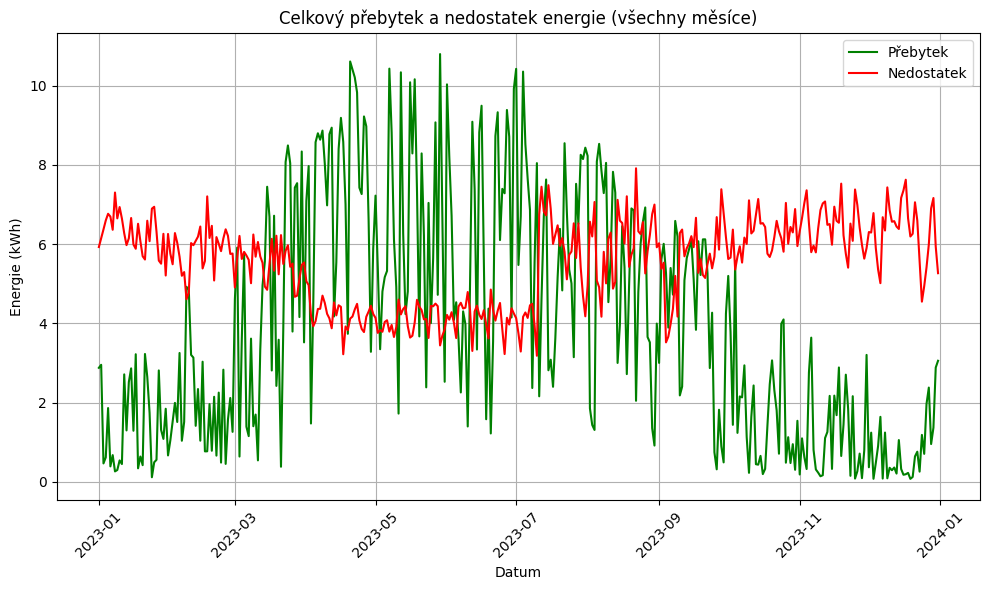

In [30]:
create_plots_total(excess, deficit, title='Celkový přebytek a nedostatek energie (všechny měsíce)', name='total_all.png')


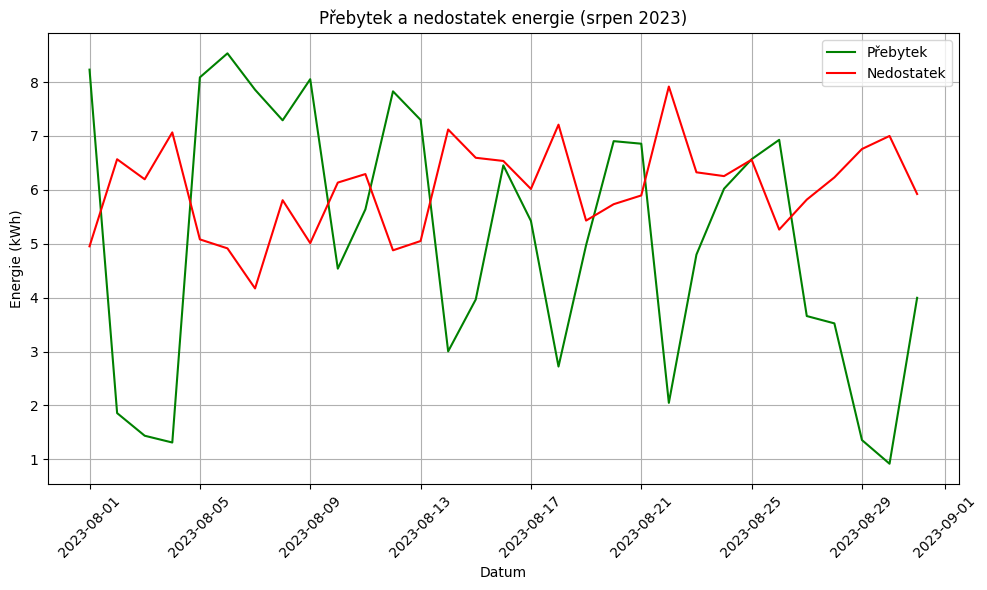

In [31]:
# Filtrace srpna 2023
excess_aug = excess[excess['year_month'] == '2023-08']
deficit_aug = deficit[deficit['year_month'] == '2023-08']

create_plots_total(excess_aug, deficit_aug, title='Přebytek a nedostatek energie (srpen 2023)', name='total_august.png')


In [33]:
def plot_average_day_dual(excess: pd.DataFrame, deficit: pd.DataFrame, title: str, name: str):
    """
    Vykreslí do jednoho grafu průměrný denní průběh přebytku a nedostatku v měsíci s osou X ve formátu HH:MM.
    """
    # Zkopíruj a přidej pomocné sloupce
    excess = excess.copy()
    deficit = deficit.copy()
    excess['time_of_day'] = excess['timestamp'].dt.time
    deficit['time_of_day'] = deficit['timestamp'].dt.time

    # Vyber jen číselné sloupce
    excess_cols = excess.select_dtypes(include='number').columns
    deficit_cols = deficit.select_dtypes(include='number').columns

    # Skupinový průměr podle času během dne
    avg_excess = excess.groupby('time_of_day')[excess_cols].mean().sum(axis=1)
    avg_deficit = deficit.groupby('time_of_day')[deficit_cols].mean().sum(axis=1)

    # Převedení indexu na datetime pro lepší formátování osy X
    time_index = pd.to_datetime(avg_excess.index.astype(str), format='%H:%M:%S')

    # Vykreslení
    plt.figure(figsize=(10, 6))
    plt.plot(time_index, avg_excess, label='Přebytek', color='green')
    plt.plot(time_index, avg_deficit, label='Nedostatek', color='red')
    plt.title(title)
    plt.xlabel('Čas během dne')
    plt.ylabel('Průměrná energie (kWh)')

    # Formát osy X: HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'/home/miro/Bachelor/BT/Outputs/{name}')
    plt.show()


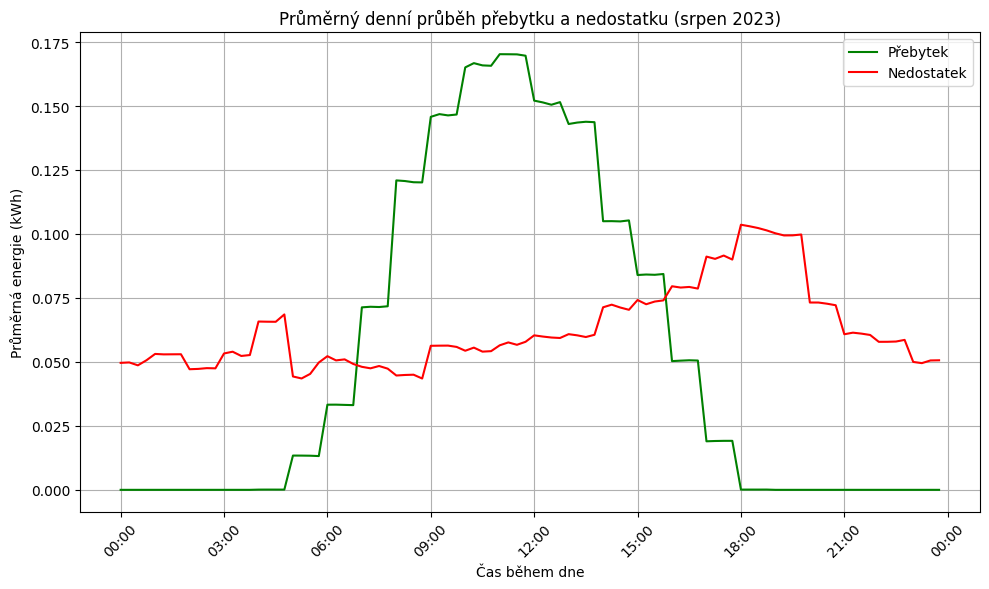

In [34]:
excess_aug = excess[excess['year_month'] == '2023-08']
deficit_aug = deficit[deficit['year_month'] == '2023-08']

plot_average_day_dual(
    excess_aug,
    deficit_aug,
    title='Průměrný denní průběh přebytku a nedostatku (srpen 2023)',
    name='avg_day_dual_august.png'
)